# Data Science for Mobility / Intro to Business Analytics

# Lecture 9 - Nuts and bolts of Machine Learning

In this lecture, we will revisit the predictive maintenance case study that we considered in the last lecture. In doing so, we will explore some of the important Machine Learning concepts that are covered by Lecture 7 like different train/test distributions, overfitting, underfitting, regularization, etc.

In [53]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

%matplotlib inline
import matplotlib.pyplot as plt

#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

In [54]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

In [55]:
import tensorflow
tensorflow

<module 'tensorflow' from 'C:\\Users\\bjark\\Anaconda3\\envs\\BjarkiLord\\lib\\site-packages\\tensorflow\\__init__.py'>

### Loading data and prepare it

Lets quickly load all the data and merge it in a single Pandas Dataframe. This is not the focus of today's lecture.

In [60]:
# load data from csv
telemetry = pd.read_csv('telemetry.csv')
error_count = pd.read_csv('error_count.csv')
comp_rep = pd.read_csv('comp_rep.csv')
machines = pd.read_csv('machines.csv')
failures = pd.read_csv('failures.csv')

# format datetime field which comes in as string
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
error_count['datetime'] = pd.to_datetime(error_count['datetime'], format="%Y-%m-%d %H:%M:%S")
comp_rep['datetime'] = pd.to_datetime(comp_rep['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")

machines['model'] = machines['model'].astype('category')
machines = pd.get_dummies(machines)

# combine data from multiple sources
features = telemetry.merge(error_count, on=['datetime', 'machineID'], how='left')
features = features.merge(comp_rep, on=['datetime', 'machineID'], how='left')
features = features.merge(machines, on=['machineID'], how='left')

# prepare target variable
labeled_features = features.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
labeled_features = labeled_features.fillna('none')

# convert "failure" target variables into multiple binary targets 
# i.e. one per component indicating failure/no failure
labeled_features['comp1_fail'] = (labeled_features['failure'] == 'comp1').astype(int)
labeled_features['comp2_fail'] = (labeled_features['failure'] == 'comp2').astype(int)
labeled_features['comp3_fail'] = (labeled_features['failure'] == 'comp3').astype(int)
labeled_features['comp4_fail'] = (labeled_features['failure'] == 'comp4').astype(int)

Define features that we will be using for training the classifiers:

In [59]:
features_to_use = ['voltmean_3h', 'rotatemean_3h', 'pressuremean_3h', 'vibrationmean_3h', # telemetry features (3h)
                   'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h', 'vibrationsd_3h', 
                   'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', # telemetry feat (24h)
                   'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h', 
                   'error1count', 'error2count', 'error3count', 'error4count', 'error5count', # errors over last 24h
                   'comp1', 'comp2', 'comp3', 'comp4', # days since last component replacement
                   'model_model1', 'model_model2', 'model_model3', 'model_model4', 'age'] # machine characteristics

target_variables = 'comp1_fail' # whether or not component 1 will fail in the next 24h

# Part 1: Different train/test distribution

Do you still remember the way we splitted the dataset into train, validation and test sets? 

<div>
    <br/>
    <img src="http://mlsm.man.dtu.dk/wp-content/uploads/2019/10/val_set.png" width="300"/>
</div>

Recall that we set aside a validation set that we used for coming up with a good neural network architecture and for performing hyper-parameter tuning. This is how we split the data:

- Train set: all data until 2015-05-31 01:00:00

- Validation set: data between 2015-06-01 01:00:00 and 2015-07-31 01:00:00

- Test set: all data after 2015-08-01 01:00:00

Let's consider this split again, create the different train, validation and test sets, and standardize the data. 

In [58]:
# define cutoff between trainset and testset
trainset_end = pd.to_datetime('2015-05-31 01:00:00')
validationset_start = pd.to_datetime('2015-06-01 01:00:00')
validationset_end = pd.to_datetime('2015-07-31 01:00:00')
testset_start = pd.to_datetime('2015-08-01 01:00:00')

# train/val/test split
X_train = labeled_features.loc[labeled_features['datetime'] < trainset_end, features_to_use]
y_train = labeled_features.loc[labeled_features['datetime'] < trainset_end, target_variables]
X_val = labeled_features.loc[((labeled_features['datetime'] > validationset_start) & (labeled_features['datetime'] < validationset_end)), features_to_use]
y_val = labeled_features.loc[((labeled_features['datetime'] > validationset_start) & (labeled_features['datetime'] < validationset_end)), target_variables]
X_test = labeled_features.loc[labeled_features['datetime'] > testset_start, features_to_use]
y_test = labeled_features.loc[labeled_features['datetime'] > testset_start, target_variables]

print("Num train examples:", len(y_train))
print("Num validation examples:", len(y_val))
print("Num test examples:", len(y_test))

Num train examples: 119117
Num validation examples: 48005
Num test examples: 121920


Notice that so far we haven't standardized the data. Let's first see how that can affect the learned classifiers.

Function to evaluate predictions from last time:

In [62]:
# function to evaluate predictions
def evaluate(y_true, y_pred, print_cm=False):
    # calculate and display confusion matrix
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if print_cm:
        print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
        print(cm)

    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true, y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true, y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("f1 score:", f1)

Let us now take a logistic regression model as an example, fit it and evaluate it on the **unstandardized** train and test sets. Note that, since it is not the focus of this notebook, in this case, we are not using the validation set to tune any hyper-parameters of the model. However, normally, you should do that. And make sure that you always do it using the validation set and not the test set! :-)

In [63]:
from sklearn.linear_model import LogisticRegression

# estimate model on trainset
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train)
print("- Test set results:")
evaluate(y_test, y_pred_test)

C:\Users\bjark\Anaconda3\envs\BjarkiLord\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


- Train set results:
accuracy: 0.9939974982580152
precision: 0.3422459893048128
recall: 0.0975609756097561
f1 score: 0.15183867141162513
- Test set results:
accuracy: 0.9954806430446195
precision: 0.4594594594594595
recall: 0.0940959409594096
f1 score: 0.1562021439509954


Ok, let's now have a look at the version with the standardized data:

In [64]:
# standardize data
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [65]:
# estimate model on trainset
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train)
print("- Test set results:")
evaluate(y_test, y_pred_test)

- Train set results:
accuracy: 0.9989338213689062
precision: 0.8794835007173601
recall: 0.9344512195121951
f1 score: 0.9061345158906134
- Test set results:
accuracy: 0.9985236220472441
precision: 0.8389513108614233
recall: 0.8265682656826568
f1 score: 0.8327137546468402


Much better, right? Of course that how much standardization affects your results will also vary depending on what ML algorithm you use. Some are more sensitive to it (e.g. kNN, SVM with RBF kernel and Gaussian Processes) than others (e.g. Decision Trees). And in some cases you may not even want to standardize your data at all (e.g. when you want to interpret the coefficients of a linear regression model)! But, in general, you should standardize your data.

But let's get back to analysing the results. You should have noticed something unusual in the results: the f1 score for the trainset is much better than the f1 score for the testset. Why do you think that happens? 

A possible reason is that the train distribution is different than the test distribution. This makes sense given the way we splitted the data: the train data is from between January and June, while the test data is from between August and December. But, in this case, could we have done something else? Unfortunatelly, not really... We need to respect the temporal order of the observations if we want our experimental setup to be realistic! Otherwise, it would be "cheating". In practice, when deployed, your ML algorithm will never have access to data from the future...

But it is still interesting to consider this hypotheses and explore it further, so that we can know how much this train-test distribution mismatch is affecting the results of the model. To do so, we will make an experiment: we will ignore the temporal order of the observations, and perform a random split.

Let us first recall the sizes of the previous train, validation and test sets:

In [70]:
print("Num train examples:", len(y_train))
print("Num validation examples:", len(y_val))
print("Num test examples:", len(y_test))

Num train examples: 119117
Num validation examples: 48005
Num test examples: 121920


Can you now create a new data split - **give the variables a different name so that we don't overwrite the previous ones!** - with the same sizes as before, but where you first shuffle the Pandas Dataframe? You can use the function "sklearn.utils.shuffle" to shuffle a Pandas Dataframe. Please ensure that the different sets don't overlap and that they have the same sizes as before!

In [71]:
from sklearn.utils import shuffle
shuffled_features = shuffle(labeled_features)

# train/val/test split
X_train_shuffled = shuffled_features[:119117][features_to_use]
y_train_shuffled = shuffled_features[:119117][target_variables]
X_val_shuffled = shuffled_features[119117:(119117+48005)][features_to_use]
y_val_shuffled = shuffled_features[119117:(119117+48005)][target_variables]
X_test_shuffled = shuffled_features[-121920:][features_to_use]
y_test_shuffled = shuffled_features[-121920:][target_variables]

# standardize data
X_mean = X_train_shuffled.mean(axis=0)
X_std = X_train_shuffled.std(axis=0)
X_train_shuffled = (X_train_shuffled - X_mean) / X_std
X_val_shuffled = (X_val_shuffled - X_mean) / X_std
X_test_shuffled = (X_test_shuffled - X_mean) / X_std

print("Num train examples:", len(y_train_shuffled))
print("Num validation examples:", len(y_val_shuffled))
print("Num test examples:", len(y_test_shuffled))

Num train examples: 119117
Num validation examples: 48005
Num test examples: 121920


Let's now fit the neural net again and evaluate it. Can you do it?

In [72]:
# estimate model on trainset
model = LogisticRegression(random_state=42)
model.fit(X_train_shuffled, y_train_shuffled)

# make predictions
y_pred_train = model.predict(X_train_shuffled)
y_pred_test = model.predict(X_test_shuffled)

print("- Train set results:")
evaluate(y_train_shuffled, y_pred_train)
print("- Test set results:")
evaluate(y_test_shuffled, y_pred_test)

- Train set results:
accuracy: 0.9987743143296087
precision: 0.8615863141524106
recall: 0.9067103109656302
f1 score: 0.8835725677830941
- Test set results:
accuracy: 0.99873687664042
precision: 0.8555729984301413
recall: 0.8978583196046128
f1 score: 0.8762057877813506


How are the results now? Again, remember that they can vary a bit due to the randomness of the shuffling of the data. But you should now have obtained more similar results between train and test sets. Maybe the f1 score for the trainset is still a bit higher than testset, but they are all now close to each other. Therefore, this suggests that the differences between the different f1 scores that we observed before are indeed due to a train-test distribution mismatch! 

Ok, but why should we care? Well, this could inform us about various things:

1) There is possibly a data sparsity/generalization issue, and that is a possible explanation for why shuffling the data before splitting increases the performance on the testset - since we shuffled the data, it is now more likely that we encounter in the trainset similar data points to the testset (e.g. 2 data points just 3h apart for the same failure situation). Hence, if we wish to further improve the quality of the model's predictions, collecting more data may be a good direction to invest!

2) If we were to use this ML algorithm in practice, we now know that there possibly is a distribution drift in the data over time. Therefore, if we were to deploy this ML algorithm, it would probably be a good idea to re-train it often using the most recent data, and also using the largest amount of data possible (because of the previous point). 

Does that make sense to you? If not, do not hesitate to ask for a clarification! But the most important thing is that this encourages you to start thinking critically about the results that you get when doing ML :-)

# Part 2: Overfitting and underfitting

We will now study the issues of overfitting and underfitting. Actually, we can see the train/test distribution mismatch also as an overfitting problem. The model is "too focused" on fitting the data points in the trainset, and it fails to generalize well to slightly different data points (like the ones in the test set). 

Let us recap the logistic model from above:

In [43]:
# estimate model on trainset
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train)
print("- Test set results:")
evaluate(y_test, y_pred_test)

- Train set results:
accuracy: 0.9989338213689062
precision: 0.8794835007173601
recall: 0.9344512195121951
f1 score: 0.9061345158906134
- Test set results:
accuracy: 0.9985236220472441
precision: 0.8389513108614233
recall: 0.8265682656826568
f1 score: 0.8327137546468402


We will now consider a very popular technique for combating overfitting in logistic regression models (and also linear regression, neural networks, etc.): **regularization**.

For example, $\ell_2$-regulrization works by extending the objective function that is minimized during the training of a logistic regression model with the following term: 

$\dots + \lambda \sum_{j} w_j^2$

You can see this extra term as penalty for the weights $\{w_j\}$ getting too large. Large weights will cause large fluctuations of the output with small changes in the input - violates smooth assumption of the output, and therefore leads to overfitting.

In the logistic regression implementation of sklearn, this term is already considered by default. We can control the amount of regularization by changing the value of the parameter $\lambda$ - called "C" in the sklearn interface (note that in sklearn it is parametrized as $C=1/\lambda$). Example: 

> model = LogisticRegression(C=1)

Therefore, you can see the "C" as controlling the smoothness of the decision boundary learned by the logistic regression classifier:

<div>
    <br/>
    <img src="https://miro.medium.com/max/1648/1*JZbxrdzabrT33Yl-LrmShw.png" width="500"/>
</div>

Can you give it a try and see how it affects the results? (the default value in sklearn is "C=1")

In [73]:
# estimate model on trainset
model = LogisticRegression(C=0.1, random_state=42)
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train)
print("- Test set results:")
evaluate(y_test, y_pred_test)

- Train set results:
accuracy: 0.9989170311542434
precision: 0.8780487804878049
recall: 0.9329268292682927
f1 score: 0.9046563192904656
- Test set results:
accuracy: 0.9985564304461942
precision: 0.8414179104477612
recall: 0.8321033210332104
f1 score: 0.836734693877551


Did you noticed the effect of the value of "C"? Higher values of C (e.g. C > 1) lead to more overfitting. But a lower value of C can be use to prevent overfitting. Try setting C=0.1. What happened? You should have noticed that the trainset f1 score went down, but the f1 score for the testset actually increased! So, by setting C=0.1, we increased the strenght of the penalty $\lambda = 1/C$, and by doing so, we managed to reduce overfitting and that reduction actually improved the generalization ability of the model!

**One important note:** Like any other model hyper-parameter, the "optimal" value of C should be tuned using the validation set! Not by relying on the results on the testset.

But, in this notebook, we are just interesting in comprehending the effect of regularization. Try setting C=0.01. What happens?

In [74]:
# estimate model on trainset
model = LogisticRegression(C=0.01, random_state=42)
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train)
print("- Test set results:")
evaluate(y_test, y_pred_test)

- Train set results:
accuracy: 0.9989170311542434
precision: 0.876967095851216
recall: 0.9344512195121951
f1 score: 0.9047970479704797
- Test set results:
accuracy: 0.9986220472440945
precision: 0.8475836431226765
recall: 0.8413284132841329
f1 score: 0.8444444444444444


For C=0.01, the model underfits! The decision boundary learned is so "smooth" that it does not even has enough flexibility to perform well on the trainset. Therefore, the trainset f1 went down from 0.90 to 0.79. Moreover, as a consequence of this decresed flexibility of the model, the testset f1 also went down.

As you hopefully were able to notice from this simple experiment, controlling overfitting can be extremely difficult. That is why it is considered one of the main problems in ML (if not THE main problem...).

# Part 3: L1 vs L2 regularization

But there is another popular type of regularization: $\ell_1$-regularization (also known as the "LASSO" penalty). It works by extending the objective function that is minimized during the training of a logistic regression model with the following term: 

$\dots + \lambda \sum_{j} |w_j|$

Compare this penalty with the term used by $\ell_2$-regularization. What is the effect of taking the absolute value instead of the square? Here is a visual comparison of the penalty value (y-axis) for different values of $w$ (x-axis). The blue line shows the penalty of $\ell_2$-regularization, while the red line corresponds to $\ell_1$-regularization.

<div>
    <br/>
    <img src="https://miro.medium.com/max/1056/1*AgA43f_6wcNKZX4p-FmL8w.png" width="500"/>
</div>

Notice how with $\ell_1$-regularization (red line) the value of penalty increases dramatically when you move just a little a bit away from $w=0$ in the x-axis. As a consequence, $\ell_1$-regularization is sparsity inducing, i.e. it encourages the weight of less important features to go towards zero. 

Let's make a comparison between $\ell_1$ and $\ell_2$-regularization in our logistic regression classifier from before. We start by running it again with "C=0.1", and having a look at the learned coefficients (or weights, or parameters... whatever you want to call them :-)

In [75]:
# estimate model on trainset
model = LogisticRegression(C=0.1, random_state=42)
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train)
print("- Test set results:")
evaluate(y_test, y_pred_test)

- Train set results:
accuracy: 0.9989170311542434
precision: 0.8780487804878049
recall: 0.9329268292682927
f1 score: 0.9046563192904656
- Test set results:
accuracy: 0.9985564304461942
precision: 0.8414179104477612
recall: 0.8321033210332104
f1 score: 0.836734693877551


In [76]:
model.coef_

array([[ 0.53941918,  0.01973789, -0.05243031,  0.0552412 , -0.05976697,
         0.13897383, -0.03264661,  0.01221998,  1.64861569,  0.14998547,
         0.19679233, -0.50142505, -0.031047  , -0.241858  ,  0.16599654,
         0.14132309,  1.4536003 , -0.07507467,  0.15424094,  0.11965965,
         0.07250787,  0.49786446,  0.07400056, -0.03453677,  0.20800093,
         0.21067649, -0.17888567,  0.0646234 , -0.08760611,  0.0361953 ]])

Now let's fit the logistic regression classifier again, but let's switch the regularization type to $\ell_1$. This can be done adding the keyword parameter "penalty='l1'" to the "LogisticRegression()" constructor call. 

In [81]:
# estimate model on trainset
model = LogisticRegression(penalty='l1', C=0.1, random_state=42)
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("- Train set results:")
evaluate(y_train, y_pred_train)
print("- Test set results:")
evaluate(y_test, y_pred_test)

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

In [79]:
model.coef_

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

What do you think of those coefficients? A lot of them are zero! What do you think that means in a linear model like logistic regression? If the coeffient is zero, then that feature takes absolutely no role in determining the class according to that model - i.e. the feature is deemed irrelevant. Interestingly, in this case, it seems that doing so leads to better generalization to the testset (better f1 score in the testset). So, rather than helping the classifier, maybe those features were actually hurting the performance of the model... Removing irrelevant features helps dealing with the curse of dimensionality! 

Write a piece of code that looks up feature names in the array "features_to_use" declared above that correspond to those zeros - i.e. the names of the features deemed irrelevant by the logistic regression model with $\ell_1$-regularization:

In [80]:
for i in range(len(features_to_use)):
    if model.coef_[0][i] == 0:
        print("Feature %s is irrelevant" % (features_to_use[i],))

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

# Part 4: Regularization in Neural Networks

For this last part we will consider overfitting and regularization techniques in neural networks. 

Since we will be training and testing quite a few different models, let us define two functions:

```
model, history = fit_nnet(X_train, y_train, X_val, y_val, num_epochs=15, batch_size=2048) # fits a neural network to the data
```

```
eval_nnet(model, X_new, y_true) # evaluates the performance of the provided "model" in the provided data ("X_new", "y_true")
```

Note that the "fit_nnet" method uses a relatively straighforward neural network architecture. This is not necessarily the best architecture for this particular problem, but that is not the purpose of this notebook anyway. Our focus will be on other concepts.

Make sure the following code makes sense. You probably implemented something similar in the last lecture...

In [38]:
# function to fit nnet
def fit_nnet(X_train, y_train, X_val, y_val, num_epochs=15, batch_size=2048):
    # define the keras model
    model = Sequential()
    model.add(Dense(150, input_dim=30, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(1, activation='sigmoid'))

    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit the keras model on the dataset
    history = model.fit(X_train, y_train, validation_data=(X_val,y_val),
                        epochs=num_epochs, batch_size=batch_size, verbose=2)
    return model, history

# function to evaluate nnet on some data
def eval_nnet(model, X_new, y_true):
    # evaluate the keras model
    y_pred = model.predict(X_new)
    y_pred = (y_pred > 0.5).astype(int)

    # evaluate predictions
    evaluate(y_true, y_pred)

Let's use the functions above to fit a neural net to the standardized predictive maintenance data from before and compute the error statistics on the train, validation and test sets:

In [39]:
fitted_model, history = fit_nnet(X_train, y_train, X_val, y_val, num_epochs=10, batch_size=2048)

Train on 119117 samples, validate on 48005 samples
Epoch 1/10
 - 2s - loss: 0.1754 - accuracy: 0.9387 - val_loss: 0.0259 - val_accuracy: 0.9945
Epoch 2/10
 - 1s - loss: 0.0246 - accuracy: 0.9945 - val_loss: 0.0090 - val_accuracy: 0.9945
Epoch 3/10
 - 1s - loss: 0.0132 - accuracy: 0.9948 - val_loss: 0.0066 - val_accuracy: 0.9953
Epoch 4/10
 - 1s - loss: 0.0101 - accuracy: 0.9951 - val_loss: 0.0053 - val_accuracy: 0.9978
Epoch 5/10
 - 1s - loss: 0.0079 - accuracy: 0.9960 - val_loss: 0.0044 - val_accuracy: 0.9988
Epoch 6/10
 - 1s - loss: 0.0063 - accuracy: 0.9967 - val_loss: 0.0037 - val_accuracy: 0.9991
Epoch 7/10
 - 1s - loss: 0.0054 - accuracy: 0.9972 - val_loss: 0.0033 - val_accuracy: 0.9993
Epoch 8/10
 - 1s - loss: 0.0048 - accuracy: 0.9978 - val_loss: 0.0031 - val_accuracy: 0.9993
Epoch 9/10
 - 1s - loss: 0.0043 - accuracy: 0.9981 - val_loss: 0.0026 - val_accuracy: 0.9994
Epoch 10/10
 - 1s - loss: 0.0041 - accuracy: 0.9982 - val_loss: 0.0025 - val_accuracy: 0.9994


In [41]:
print("- Train set results:")
eval_nnet(fitted_model, X_train, y_train)
print("- Test set results:")
eval_nnet(fitted_model, X_test, y_test)

- Train set results:
accuracy: 0.9992192550181754
precision: 0.8768406961178046
recall: 0.9984756097560976
f1 score: 0.9337134711332858
- Test set results:
accuracy: 0.9990239501312336
precision: 0.8691099476439791
recall: 0.9188191881918819
f1 score: 0.8932735426008969


Neural networks are trained using stochastic gradient methods (in this case, it used an optimizer called "adam") on a non-convex objective function (or "loss function"). Therefore, convergence to a global optimum is not guaranteed. 
<div>
    <br/>
    <img src="https://qph.fs.quoracdn.net/main-qimg-f848fbbcbf279aadeacb7bd9850d5ed1" width="400"/>
</div>

When working with neural networks, it is always a good practice to plot the evolution of the train and validation losses ("losses" = "objective function being optimized") over time during training. This can be done using the "history" variable returned by the "model.fit(...)" function:

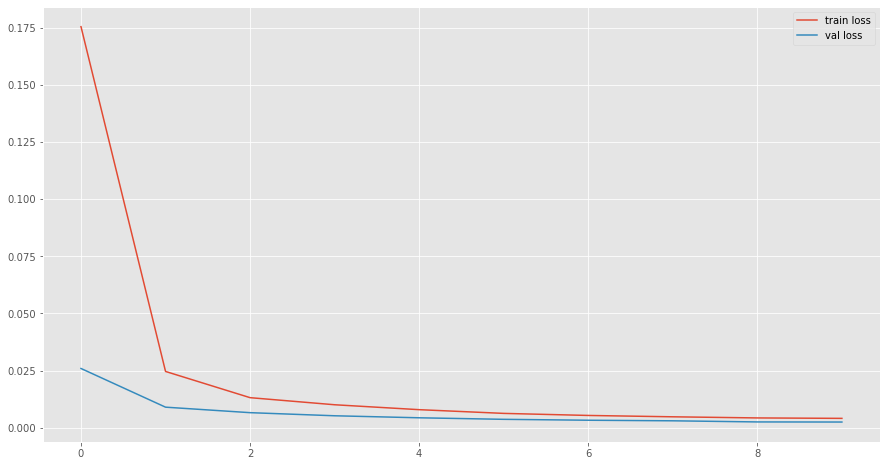

In [42]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train loss", "val loss"])
plt.show()

We can also do the same plot for the accuracy:

In [43]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["train accuracy", "val accuracy"])
plt.show()

KeyError: 'acc'

How do those plots look to you? Do you think there is any overfitting occurring? Has training converged? Or maybe we could get a better results by training for more iterations (epochs)?

Give it a try. Train the neural network using 50 epochs and plot the loss values:

In [26]:
fitted_model, history = fit_nnet(X_train, y_train, X_val, y_val, num_epochs=50, batch_size=2048)

Train on 119117 samples, validate on 48005 samples
Epoch 1/50
 - 2s - loss: 0.1785 - acc: 0.9362 - val_loss: 0.0275 - val_acc: 0.9945
Epoch 2/50
 - 1s - loss: 0.0251 - acc: 0.9945 - val_loss: 0.0092 - val_acc: 0.9945
Epoch 3/50
 - 1s - loss: 0.0134 - acc: 0.9952 - val_loss: 0.0057 - val_acc: 0.9968
Epoch 4/50
 - 1s - loss: 0.0091 - acc: 0.9960 - val_loss: 0.0046 - val_acc: 0.9986
Epoch 5/50
 - 1s - loss: 0.0066 - acc: 0.9970 - val_loss: 0.0038 - val_acc: 0.9989
Epoch 6/50
 - 1s - loss: 0.0057 - acc: 0.9976 - val_loss: 0.0035 - val_acc: 0.9991
Epoch 7/50
 - 1s - loss: 0.0052 - acc: 0.9977 - val_loss: 0.0028 - val_acc: 0.9992
Epoch 8/50
 - 1s - loss: 0.0044 - acc: 0.9982 - val_loss: 0.0026 - val_acc: 0.9992
Epoch 9/50
 - 1s - loss: 0.0039 - acc: 0.9985 - val_loss: 0.0023 - val_acc: 0.9994
Epoch 10/50
 - 1s - loss: 0.0037 - acc: 0.9985 - val_loss: 0.0022 - val_acc: 0.9993
Epoch 11/50
 - 1s - loss: 0.0035 - acc: 0.9987 - val_loss: 0.0025 - val_acc: 0.9992
Epoch 12/50
 - 1s - loss: 0.0031 -

In [27]:
print("- Train set results:")
eval_nnet(fitted_model, X_train, y_train)
print("- Test set results:")
eval_nnet(fitted_model, X_test, y_test)

- Train set results:
accuracy: 0.9998656782826968
precision: 0.9776119402985075
recall: 0.9984756097560976
f1 score: 0.9879336349924586
- Test set results:
accuracy: 0.9987040682414698
precision: 0.8966942148760331
recall: 0.8007380073800738
f1 score: 0.8460038986354776


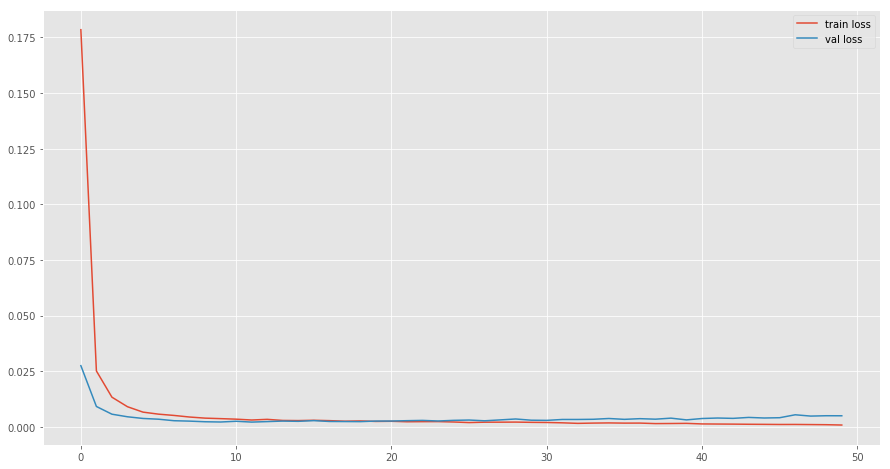

In [28]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train loss", "val loss"])
plt.show()

It is starting to overfit, isn't it? The loss on the trainset keeps decreasing, but the loss on the validation set starts to increase. We probably should have stopped around iterations 10-15...

Notice that this overfit led to a quite significant decrease in f1 score in the testset! :-(

## Dropout

A very popular regularization technique in neural nets is Dropout. In the "fit_nnet(...)" function that we defined above, we used Dropout. What happens if we now re-define the "fit_nnet" function but without the Dropout? Can you try? Let it train also for 50 epochs.

In [29]:
# function to fit nnet
def fit_nnet(X_train, y_train, X_val, y_val, num_epochs=15, batch_size=2048):
    # define the keras model
    model = Sequential()
    model.add(Dense(150, input_dim=30, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit the keras model on the dataset
    history = model.fit(X_train, y_train, validation_data=(X_val,y_val),
                        epochs=num_epochs, batch_size=batch_size, verbose=2)
    return model, history

In [30]:
fitted_model, history = fit_nnet(X_train, y_train, X_val, y_val, num_epochs=50, batch_size=2048)

Train on 119117 samples, validate on 48005 samples
Epoch 1/50
 - 1s - loss: 0.0864 - acc: 0.9844 - val_loss: 0.0120 - val_acc: 0.9951
Epoch 2/50
 - 0s - loss: 0.0061 - acc: 0.9982 - val_loss: 0.0043 - val_acc: 0.9985
Epoch 3/50
 - 0s - loss: 0.0030 - acc: 0.9991 - val_loss: 0.0032 - val_acc: 0.9988
Epoch 4/50
 - 1s - loss: 0.0025 - acc: 0.9992 - val_loss: 0.0029 - val_acc: 0.9990
Epoch 5/50
 - 1s - loss: 0.0022 - acc: 0.9993 - val_loss: 0.0028 - val_acc: 0.9989
Epoch 6/50
 - 1s - loss: 0.0021 - acc: 0.9993 - val_loss: 0.0027 - val_acc: 0.9990
Epoch 7/50
 - 1s - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0026 - val_acc: 0.9990
Epoch 8/50
 - 1s - loss: 0.0018 - acc: 0.9994 - val_loss: 0.0024 - val_acc: 0.9991
Epoch 9/50
 - 1s - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0030 - val_acc: 0.9989
Epoch 10/50
 - 1s - loss: 0.0016 - acc: 0.9994 - val_loss: 0.0033 - val_acc: 0.9989
Epoch 11/50
 - 1s - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0027 - val_acc: 0.9989
Epoch 12/50
 - 1s - loss: 0.0014 -

In [31]:
print("- Train set results:")
eval_nnet(fitted_model, X_train, y_train)
print("- Test set results:")
eval_nnet(fitted_model, X_test, y_test)

- Train set results:
accuracy: 0.9999412342486799
precision: 0.996937212863706
recall: 0.9923780487804879
f1 score: 0.9946524064171123
- Test set results:
accuracy: 0.9985236220472441
precision: 0.8605577689243028
recall: 0.7970479704797048
f1 score: 0.8275862068965517


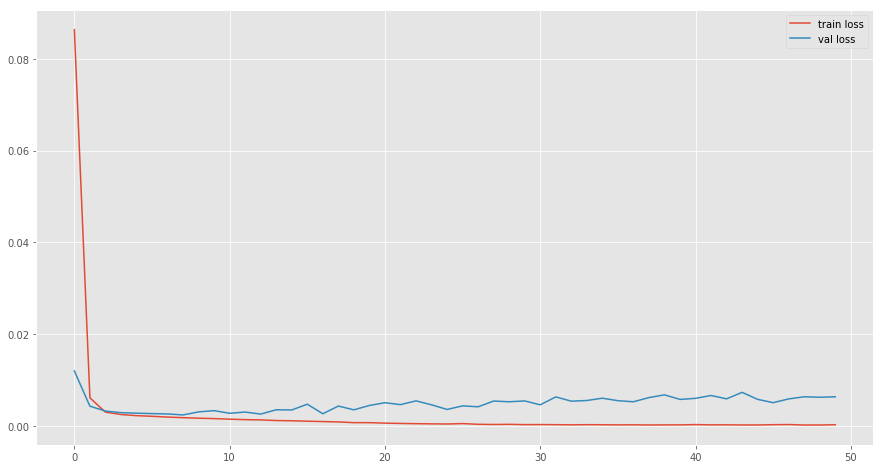

In [32]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train loss", "val loss"])
plt.show()

Overfitting is way worse now! We can conclude that Dropout was indeed helping quite a lot at preventing overfitting. 

## Regularization in Neural Networks

Like with logistic regression, we can add $\ell_1$ or $\ell_2$ penalty terms to the neural net objective function. In Keras, this is done simply by adding "kernel_regularizer=regularizers.l2(...)" to the layer definition:

```
from keras import regularizers
model.add(Dense(..., kernel_regularizer=regularizers.l2(0.001)))
```

The parameter of "regularizers.l2(...)" controls the strenght of the regularization. 

Can you try updating the "fit_nnet(...)" function from above to use $\ell_2$-regularization in the neural network? Try for example using "regularizers.l2(0.001)". Don't use Dropout. Train the neural net for 50 epochs.

In [33]:
from keras import regularizers

# function to fit nnet
def fit_nnet(X_train, y_train, X_val, y_val, num_epochs=15, batch_size=2048):
    # define the keras model
    model = Sequential()
    model.add(Dense(150, input_dim=30, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit the keras model on the dataset
    history = model.fit(X_train, y_train, validation_data=(X_val,y_val),
                        epochs=num_epochs, batch_size=batch_size, verbose=2)
    return model, history

In [34]:
fitted_model, history = fit_nnet(X_train, y_train, X_val, y_val, num_epochs=50, batch_size=2048)

Train on 119117 samples, validate on 48005 samples
Epoch 1/50
 - 1s - loss: 0.3269 - acc: 0.9703 - val_loss: 0.2085 - val_acc: 0.9945
Epoch 2/50
 - 1s - loss: 0.1773 - acc: 0.9947 - val_loss: 0.1512 - val_acc: 0.9965
Epoch 3/50
 - 1s - loss: 0.1306 - acc: 0.9987 - val_loss: 0.1125 - val_acc: 0.9989
Epoch 4/50
 - 1s - loss: 0.0988 - acc: 0.9992 - val_loss: 0.0862 - val_acc: 0.9991
Epoch 5/50
 - 1s - loss: 0.0766 - acc: 0.9992 - val_loss: 0.0673 - val_acc: 0.9993
Epoch 6/50
 - 1s - loss: 0.0605 - acc: 0.9992 - val_loss: 0.0537 - val_acc: 0.9993
Epoch 7/50
 - 1s - loss: 0.0486 - acc: 0.9993 - val_loss: 0.0433 - val_acc: 0.9995
Epoch 8/50
 - 1s - loss: 0.0397 - acc: 0.9993 - val_loss: 0.0355 - val_acc: 0.9996
Epoch 9/50
 - 1s - loss: 0.0330 - acc: 0.9993 - val_loss: 0.0300 - val_acc: 0.9995
Epoch 10/50
 - 1s - loss: 0.0279 - acc: 0.9993 - val_loss: 0.0255 - val_acc: 0.9996
Epoch 11/50
 - 1s - loss: 0.0242 - acc: 0.9993 - val_loss: 0.0222 - val_acc: 0.9996
Epoch 12/50
 - 1s - loss: 0.0213 -

In [35]:
print("- Train set results:")
eval_nnet(fitted_model, X_train, y_train)
print("- Test set results:")
eval_nnet(fitted_model, X_test, y_test)

- Train set results:
accuracy: 0.999286415876827
precision: 0.8959778085991679
recall: 0.9847560975609756
f1 score: 0.9382716049382716
- Test set results:
accuracy: 0.9990239501312336
precision: 0.8743362831858407
recall: 0.9114391143911439
f1 score: 0.8925022583559168


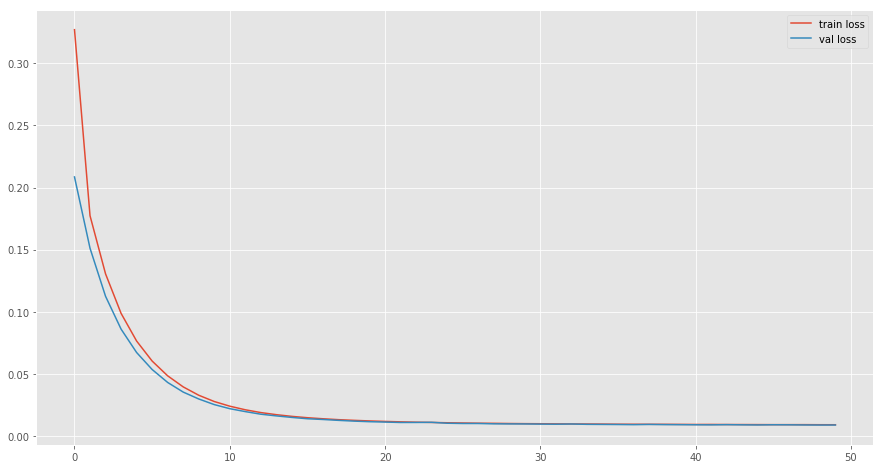

In [36]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train loss", "val loss"])
plt.show()

Effective, right? Overfitting seems to be gone and the train and testset f1 scores are now again close to each other (around 0.9). 

# Summary

Let's then recap what we learned from this notebook:

- Be careful with having different train and test set distributions - we saw a possible way to identify this issue and its potential impact on the results

- Overfitting can significatively impact your results - it is one the major issues in ML!

- We saw how regularization can be used to prevent overfitting

- We learned the differences between L1 with L2 regularization

- Dropout can be a very effect way of preventing overfitting

- L1 and L2-regularization can also be used in neural networks

We hope that you enjoyed this notebook and that you managed to get some new (and very practical!) insights from it :-)